# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    IV. Summary
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78753?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78741?</a></li>
><li><a href="#q4"> 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed?
><li><a href="#q5"> 5. What significant does the family violence factor play, in violent crime, over time? 
><li><a href="#q6"> 6. How does murder appear on the map?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I originally attempted importing the data into this notebook using Sodapy's Socrata API method but found it cumbersome. Mainly, it didn't want to work with importing the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# Importing essential libraries and configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns 
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 
              None)
plt.style.use('seaborn-white')

In [2]:
# Loading the data
df = pd.read_csv('crime_reports.csv')

In [3]:
# Examining the dataframe
display(df.info())
print('----------------------------------')
display(df.duplicated().sum())
print('----------------------------------')
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275255 entries, 0 to 2275254
Data columns (total 27 columns):
Incident Number                int64
Highest Offense Description    object
Highest Offense Code           int64
Family Violence                object
Occurred Date Time             object
Occurred Date                  object
Occurred Time                  float64
Report Date Time               object
Report Date                    object
Report Time                    float64
Location Type                  object
Address                        object
Zip Code                       float64
Council District               float64
APD Sector                     object
APD District                   object
PRA                            object
Census Tract                   float64
Clearance Status               object
Clearance Date                 object
UCR Category                   object
Category Description           object
X-coordinate                   float64
Y-coordin

None

----------------------------------


0

----------------------------------


Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20857
Address                             12
Zip Code                         13873
Council District                 46980
APD Sector                        8803
APD District                      9273
PRA                              10512
Census Tract                   1456596
Clearance Status                603166
Clearance Date                  333955
UCR Category                   1501358
Category Description           1501358
X-coordinate                      9934
Y-coordinate                      9934
Latitude                         38381
Longitude                

## II. Data Scrubbing

There are several columns of data we won't be using in the analysis, mainly other date and geodata columns. So we'll drop those and also scrub some others. Mainly, we want the zip code and address columns to be free of nulls and duplicates. 

The Clearance Status column contains 3 types of statuses: Y for Yes, N for No, and O which stands for "cleared by other means than arrest." Therefore, I changed the column, as well as the family_violence column, to boolean type. In other words, Y and O as True, and N as False. However, you may note that areas, where there is no clearance status at all, may or may not contain a corresponding date in the clearance date column. I am unsure how best to handle this so I am open to suggestions or advice.   

In [4]:
# Helper function for scrubbing the data
def clean_data(df):
    drop_col = ['Occurred Time', 
                'Occurred Date', 
                'Report Date', 
                'Report Time', 
                'Census Tract', 
                'UCR Category', 
                'Category Description', 
                'X-coordinate', 
                'Y-coordinate', 
                'Location']
    df.drop(drop_col, 
            axis=1, 
            inplace=True)
    clean_col = ['Zip Code', 
                 'Report Date Time', 
                 'Occurred Date Time', 
                 'Council District', 
                 'PRA'] 
    df.dropna(subset=clean_col, 
              inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", 
                                                          "_"), 
              inplace=True)
    """Convert the following to bools"""
    d = {'Y': True, 
         'N': False}
    e = {'C': True, 
         'O': True, 
         'N': False}
    df.clearance_status = df.clearance_status.map(e)
    df.clearance_status = df.clearance_status.astype('bool')
    df.family_violence  = df.family_violence.map(d)
    df.family_violence  = df.family_violence.astype('bool') 
    """Convert the following to datetime type"""
    date_col = ['occurred_date_time', 
                'clearance_date', 
                'report_date_time'] 
    """Convert the following to category type"""
    cat_col = ['highest_offense_description', 
               'location_type', 
               'apd_sector'] 
    df[date_col] = df[date_col].astype('datetime64') 
    df[cat_col]  = df[cat_col].astype('category') 
    """Convert the following to integer type"""
    int_col     = ['zip_code', 
                   'pra', 
                   'council_district']
    df['year']  = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.year 
    df['month'] = pd.to_datetime(df['occurred_date_time'], 
                                 format='%m/%d/%Y').dt.month 
    df['hour']  = pd.to_datetime(df['occurred_date_time'], 
                                format='%m/%d/%Y').dt.hour
    df[int_col] = df[int_col].astype('int64')
    """Set the index"""
    df.set_index(['occurred_date_time'], 
                 inplace=True)
    df.sort_index(inplace=True)
    return df
df = clean_data(df)

In [5]:
# Rechecking the dataframe 
display(df.isnull().sum())
print('----------------------------------')
display(df.dtypes)
print('----------------------------------')
display(df.head())
print('----------------------------------')
display(df.tail())

incident_number                     0
highest_offense_description         0
highest_offense_code                0
family_violence                     0
report_date_time                    0
location_type                   19553
address                             0
zip_code                            0
council_district                    0
apd_sector                          0
apd_district                        0
pra                                 0
clearance_status                    0
clearance_date                 321639
latitude                        27222
longitude                       27222
year                                0
month                               0
hour                                0
dtype: int64

----------------------------------


incident_number                         int64
highest_offense_description          category
highest_offense_code                    int64
family_violence                          bool
report_date_time               datetime64[ns]
location_type                        category
address                                object
zip_code                                int64
council_district                        int64
apd_sector                           category
apd_district                           object
pra                                     int64
clearance_status                         bool
clearance_date                 datetime64[ns]
latitude                              float64
longitude                             float64
year                                    int64
month                                   int64
hour                                    int64
dtype: object

----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2003-01-01,20085024074,IDENTITY THEFT,4022,False,2008-05-10 18:36:00,RESIDENCE / HOME,7312 WHISPERING OAKS DR,78745,5,FR,1,525,True,2008-05-13,30.202175,-97.817542,2003,1,0
2003-01-01,20035022839,OBTAIN CONTROLLED SUB BY FRAUD,1808,False,2003-11-14 09:30:00,NaN,6818 AUSTIN CENTER BLVD,78731,10,BA,8,273,False,2003-12-01,30.350588,-97.751779,2003,1,0
2003-01-01,20095041149,IDENTITY THEFT,4022,False,2009-07-22 11:09:00,RESIDENCE / HOME,1941 GASTON PLACE DR,78723,1,ID,4,295,False,2009-07-28,30.312126,-97.688964,2003,1,0
2003-01-01,20105018815,IDENTITY THEFT,4022,False,2010-04-14 14:59:00,RESIDENCE / HOME,1088 PARK PLZ,78753,4,ED,3,251,True,2010-04-15,30.348871,-97.685233,2003,1,0
2003-01-01,20125033273,AGG SEXUAL ASSAULT CHILD/OBJEC,1712,False,2012-07-18 12:00:00,RESIDENCE / HOME,1100 BLOCK HARVEY ST,78702,1,CH,2,415,True,2013-02-27,NaN,NaN,2003,1,0


----------------------------------


,incident_number,highest_offense_description,highest_offense_code,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,clearance_status,clearance_date,latitude,longitude,year,month,hour
occurred_date_time,,,,,,,,,,,,,,,,,,,
2020-10-10 16:30:00,20205040801,BURGLARY OF VEHICLE,601,False,2020-10-10 18:14:00,RESIDENCE / HOME,214 W WILLIAM CANNON DR,78745,2,FR,4,513,True,NaT,30.194629,-97.781863,2020,10,16
2020-10-10 16:38:00,20202840806,POSS/PROMO CHILD PORNOGRAPHY,2605,False,2020-10-10 16:38:00,RESIDENCE / HOME,6702 N LAMAR BLVD,78757,7,ID,7,277,True,NaT,30.335060,-97.721115,2020,10,16
2020-10-10 17:07:00,20205040793,IDENTITY THEFT,4022,False,2020-10-10 17:07:00,RESIDENCE / HOME,1818 SOUTH LAKESHORE BLVD,78741,9,HE,2,441,True,NaT,30.245289,-97.728152,2020,10,17
2020-10-10 19:23:00,20205040806,IDENTITY THEFT,4022,False,2020-10-10 19:23:00,RESIDENCE / HOME,501 E 8TH ST,78701,9,GE,2,382,True,NaT,30.268355,-97.737435,2020,10,19
2020-10-10 19:45:00,20205040809,VIOL OF EMERG PROTECTIVE ORDER,3008,False,2020-10-10 19:45:00,RESIDENCE / HOME,12345 ALAMEDA TRACE CIR,78727,6,AD,3,183,True,NaT,30.431378,-97.747069,2020,10,19


## III. Exploratory Analysis

First, let's get an overall look at crime rates and how they trend over time...

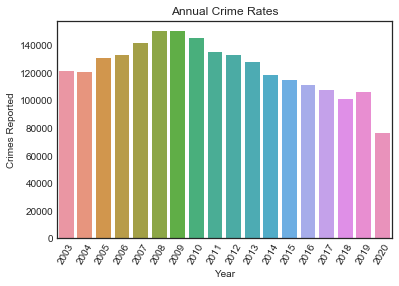

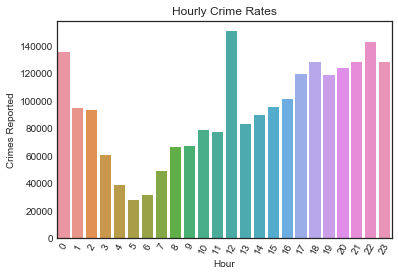

In [6]:
# Creating and visualizing a data frame for the overall yearly crime rate since 2003
crimes_per_year = df['year'].value_counts().sort_index() 

g = sns.barplot(x=crimes_per_year.index, 
                y=crimes_per_year.values)
g.set_xticklabels(g.get_xticklabels(), 
                  rotation=60)
g.set(xlabel='Year', 
      ylabel='Crimes Reported', 
      title ='Annual Crime Rates')
plt.show()

# Overall hourly crime rates as well
crimes_per_hour = df['hour'].value_counts().sort_index()

e = sns.barplot(x=crimes_per_hour.index, 
                y=crimes_per_hour.values)
e.set_xticklabels(e.get_xticklabels(), 
                  rotation=60)
e.set(xlabel='Hour', 
      ylabel='Crimes Reported', 
      title ='Hourly Crime Rates')
plt.show()

Between 2003 and now, crime peaked in 2008 and continued a downward trend until 2019 when it rose again. Since we're still in 2020, we have to wait until the end of the year to see what 2020 yields. 

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

***Note: I am only including zipcodes and crimes, for questions 1 - 3, that >= 1%. Any zipcodes or crime percentages, below 1%, will be discluded to simplify analysis and visualizations.***

Question 4 regards violent crime. For violent crime, I chose to examine 4 categories: aggrivated assault, rape, murder, and capital murder. I realize there are other types of violent crime, but for now I am sticking with these 4 categories. 

78741    203658
78753    174804
78701    161371
78758    156585
78704    151017
78745    148171
78702    134383
78744    123864
78723    115550
78752     82780
78748     66879
78759     63862
78751     63025
78757     56653
78705     56252
78721     46305
78749     39808
78724     36048
78727     35299
78703     34633
78731     27646
78746     26556
78729     23785
78750     22554
78754     22078
Name: zip_code, dtype: int64

----------------------------------


78741    0.091404
78753    0.078454
78701    0.072425
78758    0.070277
78704    0.067778
78745    0.066501
78702    0.060312
78744    0.055591
78723    0.051860
78752    0.037153
78748    0.030016
78759    0.028662
78751    0.028286
78757    0.025426
78705    0.025246
78721    0.020782
78749    0.017866
78724    0.016179
78727    0.015843
78703    0.015544
78731    0.012408
78746    0.011919
78729    0.010675
78750    0.010122
78754    0.009909
Name: zip_code, dtype: float64

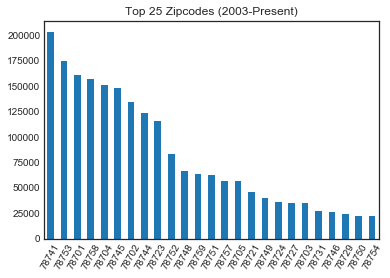

In [7]:
# Create and show dataframe for crime rates by zipcode and then as percentages
zip_codes = df.zip_code.value_counts().head(25)
display(zip_codes)
print('----------------------------------')
display(df.zip_code.value_counts(normalize=True).head(25))


# Visualizing the top 25 areas for crime 
df.zip_code.value_counts().head(25).plot.bar(rot=60, 
                                             title='Top 25 Zipcodes (2003-Present)')
plt.show()

Out of all the areas in Austin, 78741 has the highest percentage of overall crime at 9.05%. This is a significant 1.24 percentage points higher than the number 2 area 78753 which hosts 7.81% of overall crime.

#### Taking a closer look at particular areas... 

Because 78753 is my resident zipcode, I chose to examine it first. 

Next, I'll examine 78741. 

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78753? 

THEFT                             16873
BURGLARY OF VEHICLE               15737
FAMILY DISTURBANCE                14301
CRIMINAL MISCHIEF                  9192
THEFT BY SHOPLIFTING               7535
ASSAULT W/INJURY-FAM/DATE VIOL     6960
BURGLARY OF RESIDENCE              5967
DWI                                4770
DISTURBANCE - OTHER                4674
CUSTODY ARREST TRAFFIC WARR        4264
HARASSMENT                         4120
AUTO THEFT                         4063
POSS OF DRUG PARAPHERNALIA         3651
PUBLIC INTOXICATION                3305
ASSAULT WITH INJURY                3216
CRIMINAL TRESPASS                  3089
POSS CONTROLLED SUB/NARCOTIC       2916
RUNAWAY CHILD                      2875
WARRANT ARREST NON TRAFFIC         2740
POSSESSION OF MARIJUANA            2673
BURGLARY NON RESIDENCE             2414
VIOL CITY ORDINANCE - OTHER        1776
Name: highest_offense_description, dtype: int64

----------------------------------


THEFT                             0.096525
BURGLARY OF VEHICLE               0.090027
FAMILY DISTURBANCE                0.081812
CRIMINAL MISCHIEF                 0.052585
THEFT BY SHOPLIFTING              0.043105
ASSAULT W/INJURY-FAM/DATE VIOL    0.039816
BURGLARY OF RESIDENCE             0.034135
DWI                               0.027288
DISTURBANCE - OTHER               0.026739
CUSTODY ARREST TRAFFIC WARR       0.024393
HARASSMENT                        0.023569
AUTO THEFT                        0.023243
POSS OF DRUG PARAPHERNALIA        0.020886
PUBLIC INTOXICATION               0.018907
ASSAULT WITH INJURY               0.018398
CRIMINAL TRESPASS                 0.017671
POSS CONTROLLED SUB/NARCOTIC      0.016682
RUNAWAY CHILD                     0.016447
WARRANT ARREST NON TRAFFIC        0.015675
POSSESSION OF MARIJUANA           0.015291
BURGLARY NON RESIDENCE            0.013810
VIOL CITY ORDINANCE - OTHER       0.010160
Name: highest_offense_description, dtype: float64

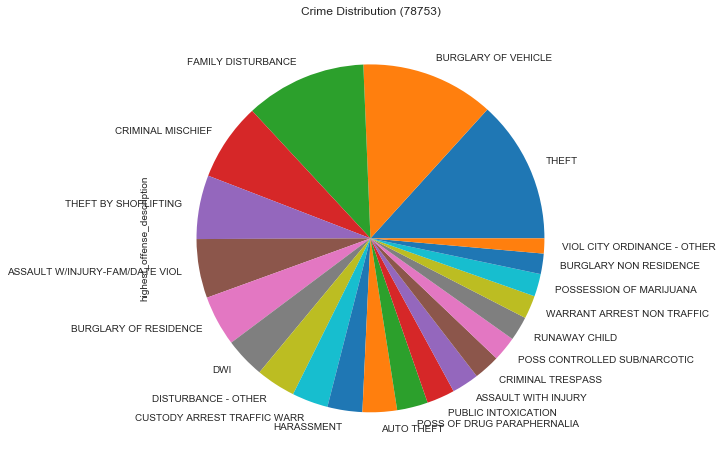

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages 
display(df_53_off)
print('----------------------------------')
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))

df_53_off.plot.pie(figsize=(8,8), 
                   title ='Crime Distribution (78753)')

<a id='q3'></a>
### C. Question 3. How is crime distributed in 78741? 

FAMILY DISTURBANCE                20035
BURGLARY OF VEHICLE               19651
THEFT                             15389
CRIMINAL MISCHIEF                 10894
ASSAULT W/INJURY-FAM/DATE VIOL     9534
BURGLARY OF RESIDENCE              8805
PUBLIC INTOXICATION                6284
CUSTODY ARREST TRAFFIC WARR        5950
DWI                                5504
HARASSMENT                         5431
DISTURBANCE - OTHER                5089
AUTO THEFT                         4504
ASSAULT WITH INJURY                4464
CRIMINAL TRESPASS                  3857
POSS CONTROLLED SUB/NARCOTIC       3803
POSSESSION OF MARIJUANA            3767
THEFT BY SHOPLIFTING               3551
POSS OF DRUG PARAPHERNALIA         3467
WARRANT ARREST NON TRAFFIC         3413
RUNAWAY CHILD                      2766
VIOL CITY ORDINANCE - OTHER        2164
Name: highest_offense_description, dtype: int64

----------------------------------


FAMILY DISTURBANCE                0.098376
BURGLARY OF VEHICLE               0.096490
THEFT                             0.075563
CRIMINAL MISCHIEF                 0.053492
ASSAULT W/INJURY-FAM/DATE VIOL    0.046814
BURGLARY OF RESIDENCE             0.043234
PUBLIC INTOXICATION               0.030856
CUSTODY ARREST TRAFFIC WARR       0.029216
DWI                               0.027026
HARASSMENT                        0.026667
DISTURBANCE - OTHER               0.024988
AUTO THEFT                        0.022116
ASSAULT WITH INJURY               0.021919
CRIMINAL TRESPASS                 0.018939
POSS CONTROLLED SUB/NARCOTIC      0.018673
POSSESSION OF MARIJUANA           0.018497
THEFT BY SHOPLIFTING              0.017436
POSS OF DRUG PARAPHERNALIA        0.017024
WARRANT ARREST NON TRAFFIC        0.016758
RUNAWAY CHILD                     0.013582
VIOL CITY ORDINANCE - OTHER       0.010626
Name: highest_offense_description, dtype: float64

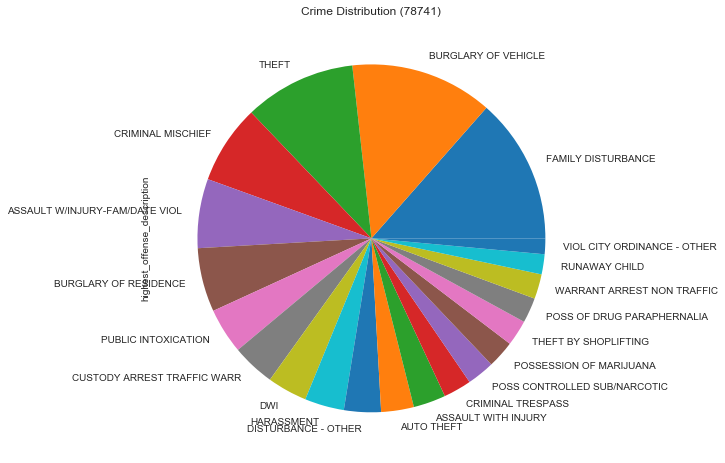

In [9]:
# Create a dataframe for crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top 10 crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages 
display(df_41_off)
print('----------------------------------')
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))

df_41_off.plot.pie(figsize=(8,8), 
                   title ='Crime Distribution (78741)')

<a id='q4'></a>
### D. Question 4. How are violent crimes, in particular murder, capital murder, aggrivated assault, and rape distributed? 

***The following line of code shows crime rates only >= 1% per zipcode.***

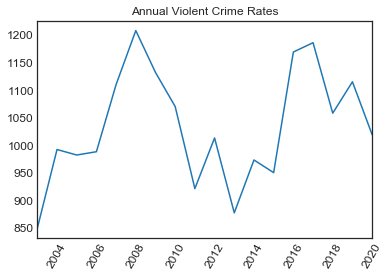

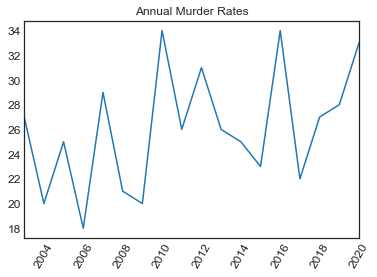

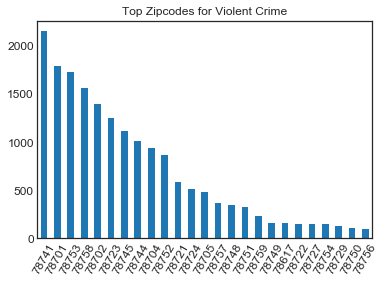

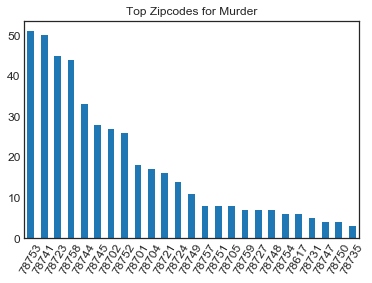

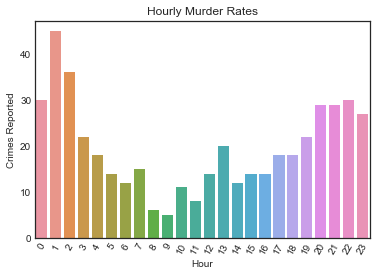

highest_offense_description,AGG ASSAULT,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,
78613,14,0,1,4
78617,117,0,6,35
78652,1,0,0,0
78653,7,0,1,1
78660,59,0,2,12
78701,1422,1,17,352
78702,1182,3,24,186
78703,53,1,0,36
78704,684,2,15,241


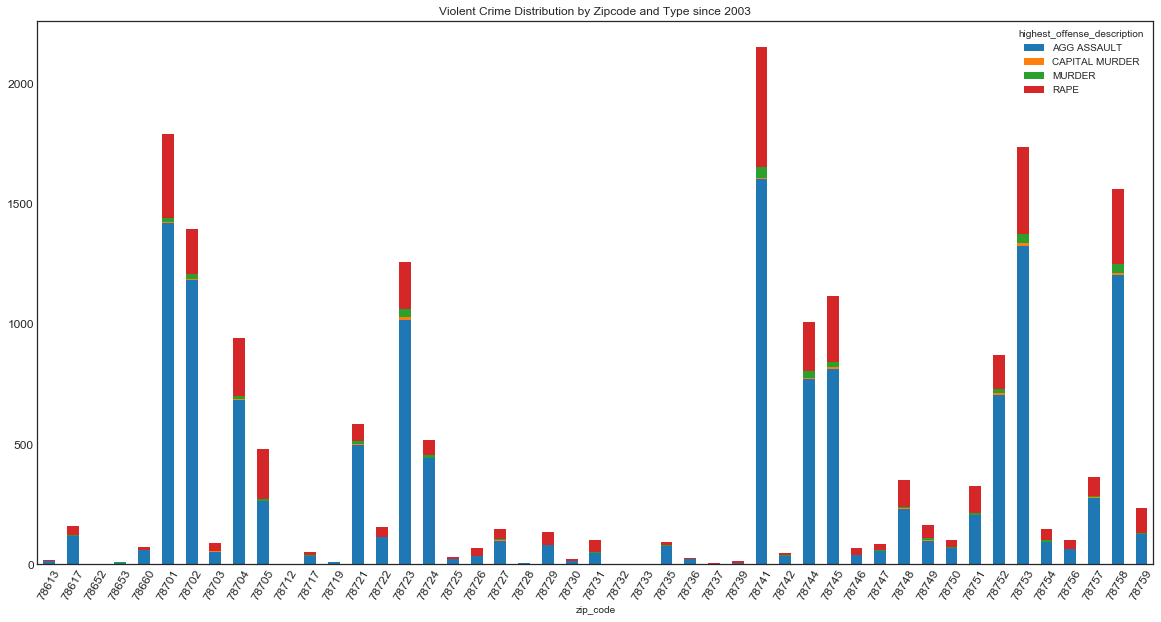

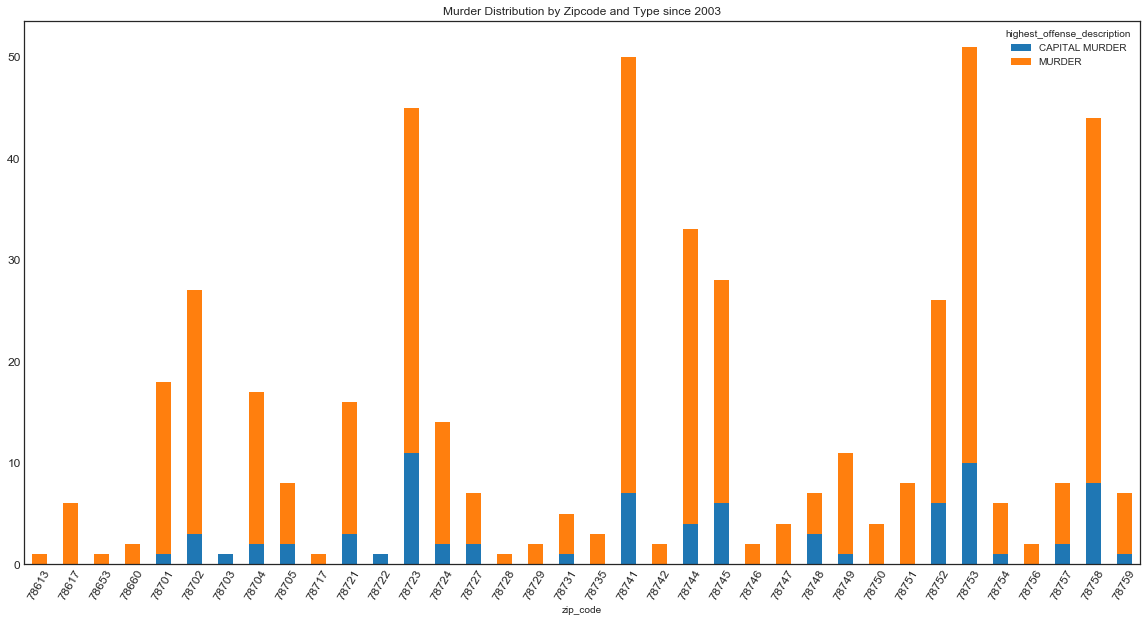

In [10]:
# Creating an overall and separate dataframes for violent crime
df_viol = df.query('highest_offense_description     == ["MURDER", "CAPITAL MURDER", "RAPE", "AGG ASSAULT"]') 
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_mur = df[df.highest_offense_description          == 'MURDER']
df_mur_cap = df[df.highest_offense_description      == 'CAPITAL MURDER']
df_agg_asslt = df[df.highest_offense_description    == 'AGG ASSAULT']
df_rape = df[df.highest_offense_description         == 'RAPE']

# Visualizing violent crimes per year
viol_per_year = df_viol['year'].value_counts().sort_index()

viol_per_year.plot.line(rot=60,
                        title='Annual Violent Crime Rates', 
                        fontsize=12)
plt.show()

# Visualizing murders per year
viol_mur_per_year = df_viol_mur['year'].value_counts().sort_index()

viol_mur_per_year.plot.line(rot=60, 
                            title='Annual Murder Rates', 
                            fontsize=12)
plt.show()

#Violent Crime by Zipcode
df_viol_zip = df_viol.zip_code.value_counts().head(25)

df_viol_zip.plot.bar(title='Top Zipcodes for Violent Crime', 
                     fontsize=12,  
                     rot=60)
plt.show()

# Murder by Zipcode
df_viol_mur.zip_code.value_counts().head(25).plot.bar(fontsize=12, 
                                                      title='Top Zipcodes for Murder', 
                                                      rot=60)
plt.show()
        
mur_by_hour = df_viol_mur['hour'].value_counts().sort_index()

# Visualizing hourly murder rate with Seaborn
f = sns.barplot(x=mur_by_hour.index, 
                y=mur_by_hour.values)
f.set_xticklabels(f.get_xticklabels(), 
                  rotation=60)
f.set(xlabel='Hour', 
      ylabel='Crimes Reported', 
      title ='Hourly Murder Rates')
plt.show()

# Calculating and visualizing frequency rate of violent crimes by zipcode
viol_freq = pd.crosstab(df_viol.zip_code, 
                        df_viol.highest_offense_description)

display(viol_freq)

viol_freq.plot.bar(figsize=(20,10), 
                   title='Violent Crime Distribution by Zipcode and Type since 2003', 
                   fontsize=12, 
                   stacked=True, 
                   rot=60)
plt.show()

viol_mur_freq = pd.crosstab(df_viol_mur.zip_code, 
                            df_viol_mur.highest_offense_description)

viol_mur_freq.plot.bar(figsize=(20,10), 
                       title='Murder Distribution by Zipcode and Type since 2003', 
                       fontsize=12, 
                       stacked=True,  
                       rot=60)
plt.show()

According to the data , 2010 and 2016 had the most number of murders . Alarmingly, this year so far has already become the 3rd most prevalent year.

<a id='q5'></a>
### E. Question 5. What significance has the family violence factor played over time? 

0.05867655724821856

----------------------------------


occurred_date_time
2003    0.040622
2004    0.046400
2005    0.050664
2006    0.054710
2007    0.058938
2008    0.058421
2009    0.055017
2010    0.052637
2011    0.060271
2012    0.061657
2013    0.057950
2014    0.057534
2015    0.062570
2016    0.066069
2017    0.067830
2018    0.074201
2019    0.070105
2020    0.075157
Name: family_violence, dtype: float64

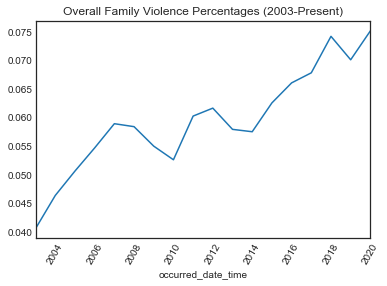

0.07908875993982377

----------------------------------


occurred_date_time
2003    0.036514
2004    0.038306
2005    0.049898
2006    0.042510
2007    0.056757
2008    0.070364
2009    0.067138
2010    0.062617
2011    0.079262
2012    0.082922
2013    0.109464
2014    0.124358
2015    0.129474
2016    0.100941
2017    0.097808
2018    0.113422
2019    0.081614
2020    0.077527
Name: family_violence, dtype: float64

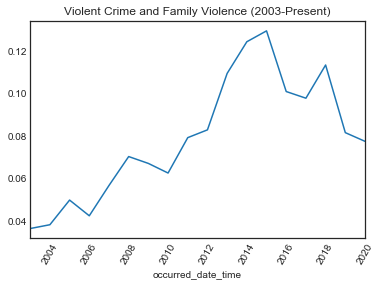

0.2068230277185501

----------------------------------


occurred_date_time
2003    0.148148
2004    0.100000
2005    0.320000
2006    0.111111
2007    0.068966
2008    0.238095
2009    0.050000
2010    0.264706
2011    0.230769
2012    0.225806
2013    0.307692
2014    0.240000
2015    0.304348
2016    0.117647
2017    0.181818
2018    0.222222
2019    0.321429
2020    0.212121
Name: family_violence, dtype: float64

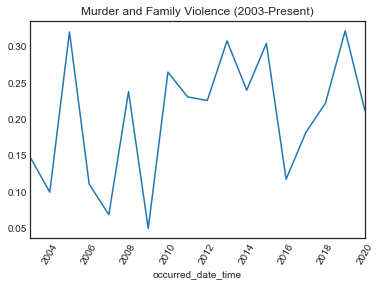

0.23347910592808552

----------------------------------


occurred_date_time
2003    0.154839
2004    0.086957
2005    0.111732
2006    0.126374
2007    0.170732
2008    0.197368
2009    0.206140
2010    0.170833
2011    0.267045
2012    0.273196
2013    0.280612
2014    0.281065
2015    0.295455
2016    0.332103
2017    0.297578
2018    0.259516
2019    0.263158
2020    0.302469
Name: family_violence, dtype: float64

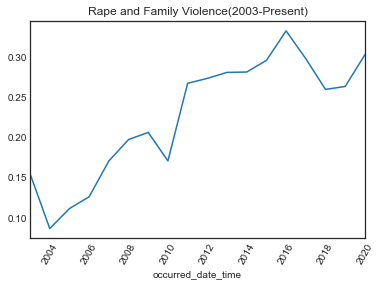

0.23347910592808552

----------------------------------


occurred_date_time
2003    0.004498
2004    0.023529
2005    0.026992
2006    0.021574
2007    0.022754
2008    0.036496
2009    0.031674
2010    0.021357
2011    0.027816
2012    0.030457
2013    0.050382
2014    0.032787
2015    0.040388
2016    0.027778
2017    0.029714
2018    0.052561
2019    0.025611
2020    0.027913
Name: family_violence, dtype: float64

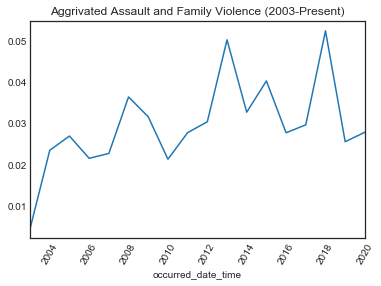

In [11]:
# Taking a look at first at the overall crime set
display(df.family_violence.mean())

print('----------------------------------')
display(df.groupby(df.index.year).family_violence.mean())

hrly_fam_viol_occurrences = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg = df.groupby(df.index.year).family_violence.mean()

fam_viol_avg.plot(rot=60, 
                  title='Overall Family Violence Percentages (2003-Present)')
plt.show()

# Now taking a look at violent crime specifically 
display(df_viol.family_violence.mean())

print('----------------------------------')
display(df_viol.groupby(df_viol.index.year).family_violence.mean())

viol_hrly_fam_viol_occurrences = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg = df_viol.groupby(df_viol.index.year).family_violence.mean()

viol_fam_viol_avg.plot(rot=60, 
                       title='Violent Crime and Family Violence (2003-Present)')
plt.show()

# Now taking a look at murder with the family violence factor included 
display(df_viol_mur.family_violence.mean())

print('----------------------------------')
display(df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean())

mur_hrly_fam_viol_occurrences = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg = df_viol_mur.groupby(df_viol_mur.index.year).family_violence.mean()

mur_fam_viol_avg.plot(rot=60, 
                      title='Murder and Family Violence (2003-Present)')
plt.show()

# Now taking a look at rape with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_rape.groupby(df_rape.index.year).family_violence.mean())

rape_hrly_fam_viol_occurrences = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg = df_rape.groupby(df_rape.index.year).family_violence.mean()

rape_fam_viol_avg.plot(rot=60, 
                       title='Rape and Family Violence(2003-Present)')
plt.show()

# Now taking a look at aggrivated assault with the family violence factor included 
display(df_rape.family_violence.mean())

print('----------------------------------')
display(df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean())

agg_asslt_fam_viol_avg = df_agg_asslt.groupby(df_agg_asslt.index.year).family_violence.mean()

agg_asslt_fam_viol_avg.plot(rot=60, 
                            title='Aggrivated Assault and Family Violence (2003-Present)')
plt.show()

Overall, family violence is seeing an upward trend as a crime factor. Violent crime saw an alarming upward trend of the family violence factor, as well. Rapes, for example, involved the family violence factor a 3rd of the time in 2016 whereas in 2004, family violence was involved less than 1% of the time. 

<a id='q6'></a>
### F. Question 6. How does murder appear on the map? 

In [12]:
# This won't work if there are NaN values in the coordinate columns
df_viol_mur.dropna(subset=['latitude', 'longitude'], 
                   inplace=True)

# Making a folium map using incident lat and lon
m = folium.Map([30.2672, -97.7431], 
               tiles='Stamen Toner', 
               zoom_level=12)

for index, row in df_viol_mur.iterrows():
	lat = row['latitude']
	lon = row['longitude']
	name= row['address']
	folium.Marker([lat, lon], 
                  popup=name).add_to(m)
    
m.save(outfile='aus_mur_map.html')

m

ED       299889
DA       288142
FR       275745
CH       268253
HE       251032
ID       246796
BA       234900
AD       202932
GE       147804
AP        10824
UT         1048
88          747
HENRY         1
Name: apd_sector, dtype: int64

3     372067
9     365588
4     334679
1     274685
2     221620
7     212102
5     170470
6      96161
10     91218
8      89523
Name: council_district, dtype: int64

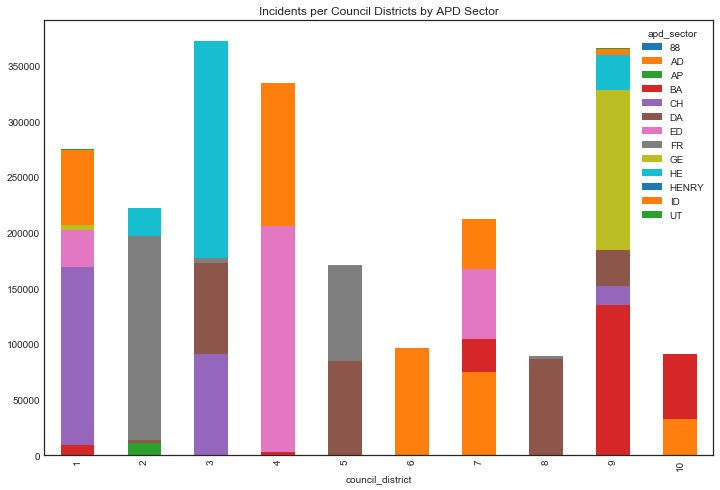

In [13]:
display(df.apd_sector.value_counts())

display(df.council_district.value_counts())

pd.crosstab(df.council_district, 
            df.apd_sector).plot.bar(stacked =True, 
                                    figsize=(12,8), 
                                    title ='Incidents per Council Districts by APD Sector')

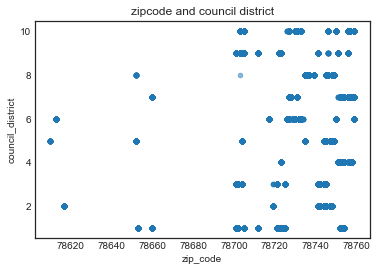

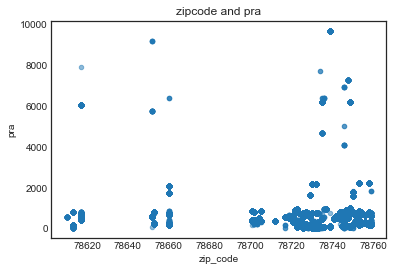

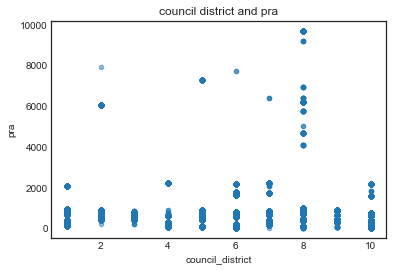

In [16]:
# Checking outliers between variables 
df.plot.scatter('zip_code', 
                'council_district', 
                title='zipcode and council district',  
                alpha = 0.5)
plt.show()

df.plot.scatter('zip_code', 
                'pra', 
                title='zipcode and pra',  
                alpha = 0.5)
plt.show()

df.plot.scatter('council_district', 
                'pra', 
                title='council district and pra',  
                alpha = 0.5)
plt.show()

## IV. Summary
Needless to say, violent crimes go hand-in-hand with other violent crimes.

So far, 78753 and 78741 are the top hotspots for all sorts of crime in Austin, including violent crime.

For non-capital murder, 78741 comes in at number 1 with 10.91%. 

#### ***It is important to note that murder does not necessarily make the defendant(s) automatically eligible for the death penalty. Under Texas law, we distinguish capital murder, through the motives and actions of the defendant(s) during the commission of a homicide, as whether or not automatically warranting an eventual date with the executioner. This includes such things as if the homicide was premeditated or not, if the defendant(s) murdered a police officer, etc.***

Regarding capital murder, 78723 comes in to share the number one spot with 78753, with a rate of 13.92% each. The 78741 area drops to the number 3 spot, carrying 8.97%. So, if we're honest, 78753 actually is the number 1 hotspot for murder because it has played host to 40 non-capital murders and 11 capital murders in total, meaning it has hosted 11% of all murders. 78741, if we combine all murders, only accounts for 10.56% of the total since 2003. 

Next, 78741 climbs back to claim the number 1 spot for rape at 12.09% -- 3.43 percentage points higher than the number 2 spot 78753 carrying 8.66% which is quite a significant lead when you look at it on the graph!! Why does rape occur so much more often in this area than in others?

A peculiar outlier is zipcode 78731. Although violent crime frequency ranks amongst the lowest there, rape accounts for over 50% of violent crimes committed in that area. Why is that? 

Astonishingly the family violence factor played an ever increasing role over over time, in regards to violent crime. From 2003 to 2015, family violence increased by nearly 10 percentage points--meaning you were likely to be the victim of a family member, during the commission of a rape, aggrivated assault, murder, or capital murder, only 3.15% of the time in 2003. But by 2015, that same likelihood rose to 12.82%!